In [4]:
mat.sub <- read.table ("CCLE_expr_bone_oesophagus_forR.txt", sep="\t", header=T)
dim (mat.sub)
mat.sub[1:5, 1:6]

[1] 18926    50

,B_GSM886836,B_GSM886859,B_GSM886901,B_GSM886912,B_GSM887015,B_GSM887088
100009676_at,6.2052,5.4153,5.5729,5.8700,5.8151,5.2842
10000_at,6.6152,4.6571,4.9790,7.8872,5.9303,6.9926
10001_at,9.9699,9.4435,9.0982,8.3093,8.1213,10.1340
10002_at,4.0304,4.0395,3.8002,3.5999,4.0901,3.8586
10003_at,3.8504,4.9709,7.0736,4.5478,4.4081,3.7288


In [5]:
# compute p-value using t-test for all the genes
p.vec <- apply (mat.sub, 1, function(x) {t.test(x[1:25], x[26:50])$p.value})
length(p.vec)



[1] 18926

##### Benjamini–Hochberg Test

Benjamini-Hochberg false discovery detection method is also another test used for correction.

###### Adjust P-values for Multiple Comparisons

We will be using the function called 'p.adjust'. Given a set of p-values, returns p-values adjusted using one of several methods.
Usage: p.adjust(p, method = p.adjust.methods)

In our case, p will be 'p.vec' matrix and method for p-value adjustment is "BH" (Benjamini–Hochberg)


In [6]:
bht <- p.adjust(p.vec, method = "BH")
length(bht)


# select indices for the genes having p-value less than 0.05 (5% significance level)
de.bht.ind <- which(bht<0.05)
length(de.bht.ind)

# select indices for the genes having p-value less than 0.01 (1% significance level)
de.bht.ind2 <- which(bht<0.01)
length(de.bht.ind2)

# save the indices for Differentially expressed genes (DE)
de.bht.vec <- dimnames(mat.sub)[[1]][de.bht.ind]
de.bht.vec[1:5]

[1] 18926

[1] 5501

[1] 3430

[1] "10001_at"     "10003_at"     "10009_at"     "1000_at"      "100101467_at"

In [7]:
# Save Benjamini–Hochberg DE probes in a new matrix
fdr.DE.mat <- mat.sub[de.bht.ind,]

##### LIMMA

LIMMA (Linear Models for Microarrays) is an established method for differential expression analyses of microarray. LIMMA accounts for the experimental design and uses an empirical Bayes approach to estimate the variance among samples. It has been shown to be a robust method for data with small sample sizes . LIMMA R package was used and two-group design matrix was considered.
http://www.bioconductor.org/packages/devel/bioc/vignettes/limma/inst/doc/usersguide.pdf

In [20]:
# Install and Load LIMMA Library

#source("https://bioconductor.org/biocLite.R")
library(GEOquery)
#biocLite("limma")
library(limma)

Bioconductor version 3.6 (BiocInstaller 1.28.0), ?biocLite for help
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from 'package:limma':

    plotMA

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdi

In [29]:
design <- cbind (BONE=1, BONEVsOESOPHAGUS=c(rep(0, 25), rep(1, 25)))
fit <- lmFit (mat.sub, design)
fit <- eBayes (fit)

In [30]:
toptable.mat <- topTable (fit, coef="BONEVsOESOPHAGUS", adjust="fdr", number=nrow(mat.sub))
toptable.mat[1:5,]

,logFC,AveExpr,t,P.Value,adj.P.Val,B
114569_at,7.635240,8.175312,27.89929,4.401214e-32,8.329738e-28,61.76885
25927_at,-5.527228,7.343606,-22.77532,5.267539e-28,3.618482e-24,53.04234
4072_at,7.577400,8.692216,22.73279,5.735732e-28,3.618482e-24,52.96199
54845_at,6.177600,7.291216,22.11387,2.010495e-27,9.512655e-24,51.77620
999_at,4.927020,6.969866,21.39715,8.910532e-27,2.993897e-23,50.36340


In [31]:
# Number of genes with adjusted p-value less than 0.05
sum(toptable.mat$adj.P.Val < 0.05)

[1] 5616

In [32]:
# Number of genes with adjusted p-value less than 0.01
sum(toptable.mat$adj.P.Val < 0.01)

[1] 3607

In [33]:
# Number of genes with adjusted p-value less than 0.001
sum(toptable.mat$adj.P.Val < 0.001)

[1] 2039

In [38]:
# Save DE genes at p < 0.05
DE.limma <- rownames(toptable.mat[toptable.mat$adj.P.Val < 0.05,])
for (i in 1:10){
print(as.character(DE.limma[i]))}

[1] "114569_at"
[1] "25927_at"
[1] "4072_at"
[1] "54845_at"
[1] "999_at"
[1] "6692_at"
[1] "50848_at"
[1] "5493_at"
[1] "4921_at"
[1] "9053_at"


In [39]:
# Save Limma's top DE (adj.P.Val < 0.05) probes in a new matrix
limma.DE.mat <- mat.sub[DE.limma,]

In [41]:
limma.DE.mat[1:5,]

,B_GSM886836,B_GSM886859,B_GSM886901,B_GSM886912,B_GSM887015,B_GSM887088,B_GSM887110,B_GSM887112,B_GSM887118,B_GSM887119,...,O_GSM887692,O_GSM887693,O_GSM887694,O_GSM887695,O_GSM887697,O_GSM887698,O_GSM887700,O_GSM887701,O_GSM887702,O_GSM887713
114569_at,4.2113,4.2452,4.7768,4.7778,4.1420,4.2896,4.1584,4.0016,3.8696,4.1096,...,13.2790,12.4450,11.9170,11.3280,12.2960,11.944,12.0620,7.1443,12.1370,11.8570
25927_at,11.6260,9.1917,11.4820,11.1010,9.8668,11.4930,10.5210,10.4840,10.3940,10.0440,...,4.6358,4.2448,3.9572,4.1572,4.5827,5.737,4.5706,4.1693,4.3264,4.6055
4072_at,7.9613,3.9262,4.3619,4.1065,4.3876,8.9929,4.4370,5.6284,4.2781,3.4155,...,12.2960,12.6400,12.1420,13.0420,12.7860,12.715,12.8120,9.7369,11.7120,12.7300
54845_at,3.8282,4.0155,5.1187,4.0778,4.0450,4.3228,4.0655,4.1024,4.1017,4.0160,...,10.7490,11.3000,10.6240,9.7096,11.1490,11.099,11.4020,7.5416,10.5330,11.6090
999_at,4.5008,4.4259,4.3239,4.2208,4.3942,4.4542,4.5792,4.4473,4.5921,4.4367,...,9.8003,7.8246,9.8857,9.5621,10.6370,10.532,8.8120,7.1866,10.0960,8.7390


In [11]:
# Install and load R Color Brewer

#install.packages("RColorBrewer",repos = "http://cran.us.r-project.org")
library("RColorBrewer")

In [9]:
# modify the distance function to use correlation - Pearson by default - (based on Yeung et al. [22])

newdist <- function (x) {as.dist (1-cor(t(x)))/2}

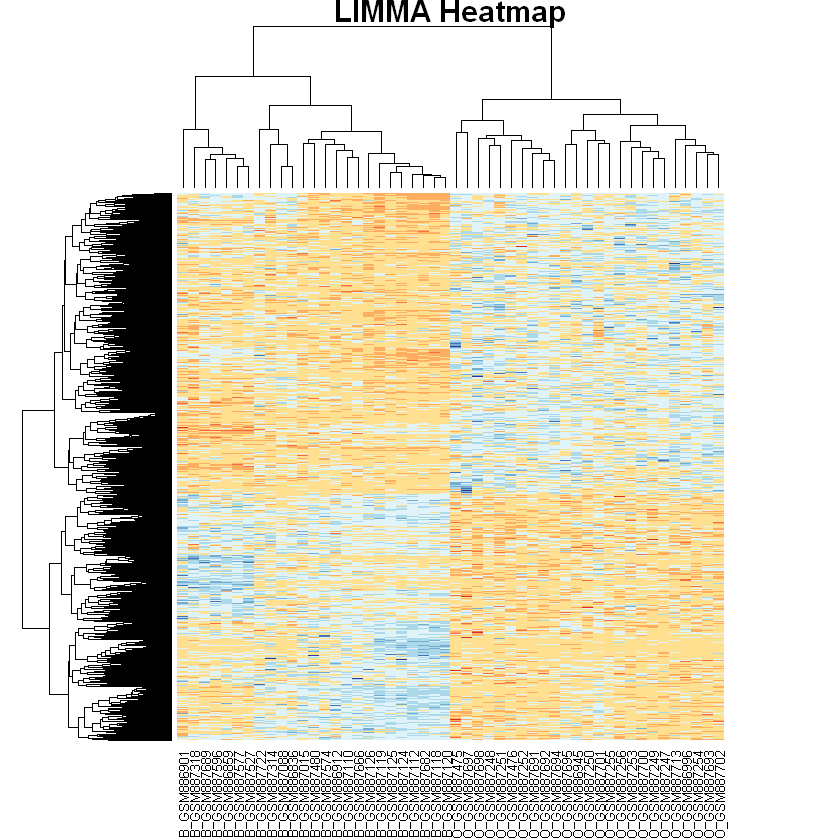

In [45]:
# Heatmap for DE genes resulted from LIMMA
heatmap (as.matrix(limma.DE.mat), distfun=newdist, labRow = FALSE, , col=brewer.pal(10,"RdYlBu"), main="LIMMA Heatmap")

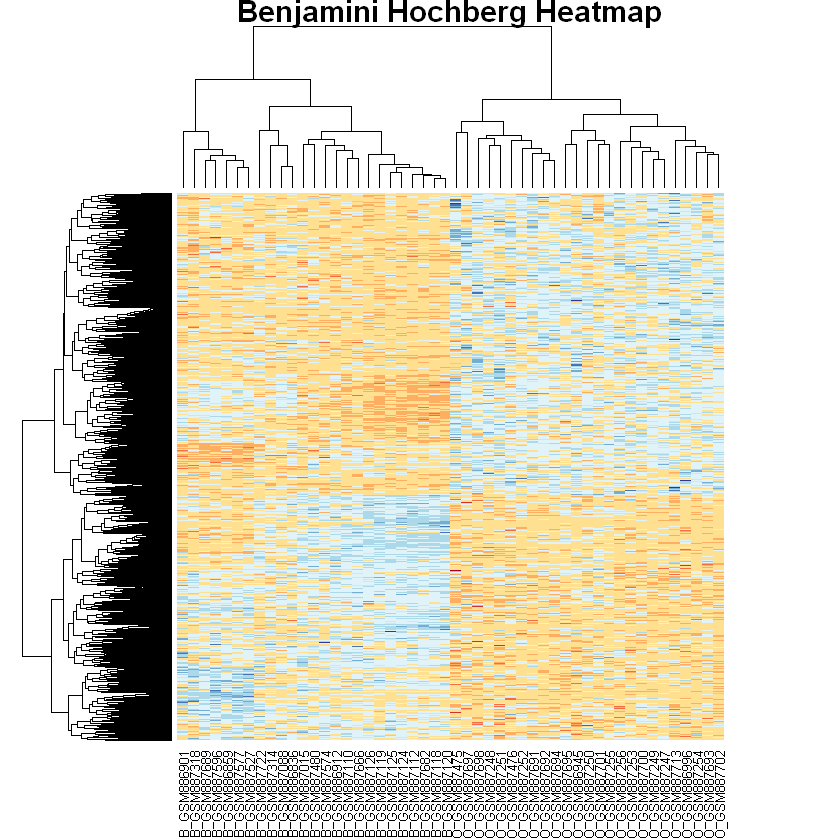

In [12]:
# Heatmap for DE genes resulted from Benjamini Hochberg (FDR)
heatmap (as.matrix(fdr.DE.mat), distfun=newdist, labRow = FALSE, , col=brewer.pal(10,"RdYlBu"), main="Benjamini Hochberg Heatmap")